In [45]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta, lambdas_to_lambda_tildes
from ripple.constants import MSUN, gt
from ripple.waveforms.utils_tidal import get_quadparam_octparam
from jax import grad, vmap
from functools import partial

%load_ext autoreload
%autoreload 2
from ripple.waveforms import TaylorF2QM
from ripple.waveforms import TaylorF2
from ripple.waveforms import utils_tidal

import lalsimulation as lalsim
import lal

from ripple import get_eff_pads

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

jax.config.update("jax_enable_x64", True) # improve precision for comparing waveforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
m1 = 3
m2 = 2
M = m1 + m2

chi1 = 0.4
chi2 = 0.5

lambda1 = 500
lambda2 = lambda1

distance = 440.
theta = (m1, m2, chi1, chi2, lambda1, lambda2)

In [47]:
# Frequency grid
T = 16
f_l = 20.0
# f_sampling = 2 * 512
f_sampling = 2 * 4096
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

v = (np.pi * M*2*10**30 * fs)

In [48]:
m1_msun = m1
m2_msun = m2
chi1 = chi1
chi2 = chi2
tc = 0
phic = 0
dist_mpc = distance
inclination = np.pi / 2

# Convert from source values to sample values
Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
lambda_tilde, delta_lambda_tilde = lambdas_to_lambda_tildes(jnp.array([lambda1, lambda2, m1, m2]))

theta_ripple = jnp.array([Mc, eta, chi1, chi2, lambda_tilde, delta_lambda_tilde, dist_mpc, tc, phic, inclination])
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

# And finally lets generate the waveform!
hp_ripple, hc_ripple = TaylorF2.gen_TaylorF2_hphc(fs_ripple, theta_ripple, f_ref)
hp_rippleQM, hc_rippleQM = TaylorF2QM.gen_TaylorF2_hphc(fs_ripple, theta_ripple, f_ref)

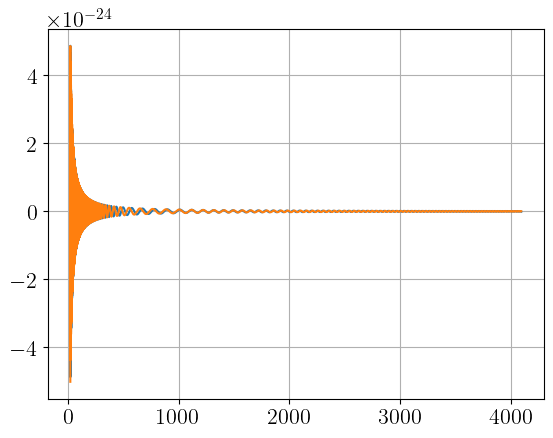

In [49]:
#Compare TaylorF2 (blue) to TaylorF2QM (orange)
plt.plot(fs_ripple, hp_ripple.real)
plt.plot(fs_ripple, hp_rippleQM.real)
plt.show()

(0.0, 1500.0)

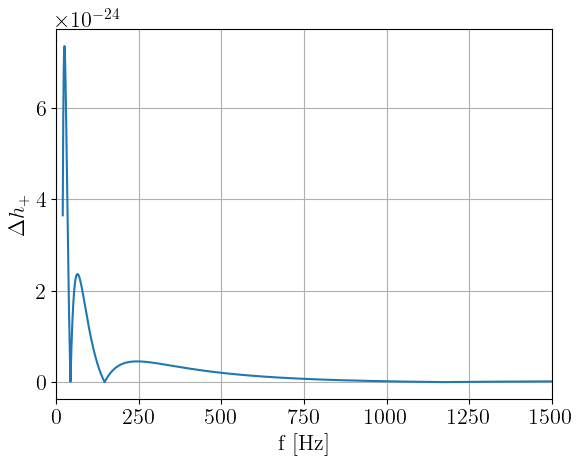

In [50]:
#Filter out the QM contribution:
hp_QM = np.abs(hp_rippleQM - hp_ripple)
plt.plot(fs_ripple, hp_QM)
plt.ylabel(r"$\Delta h_+$")
plt.xlabel("f [Hz]")
plt.xlim(0, 1500)

Text(0, 0.5, '$\\Psi_{QM}$')

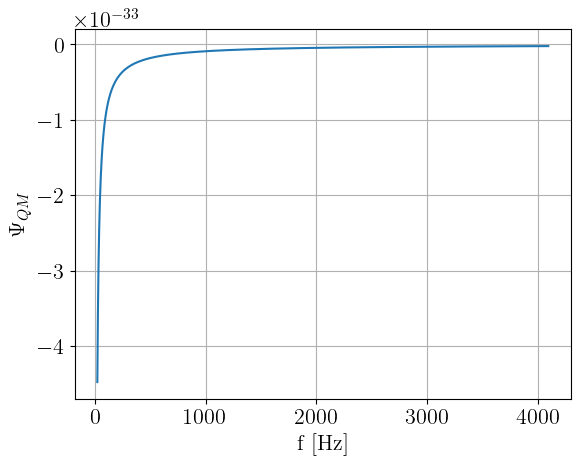

In [51]:
psi_QM = utils_tidal.get_spin_induced_quadrupole_phase(v, theta)

plt.plot(fs, psi_QM)
plt.xlabel("f [Hz]")
plt.ylabel(r"$\Psi_{QM}$")